[*********************100%%**********************]  1 of 1 completed


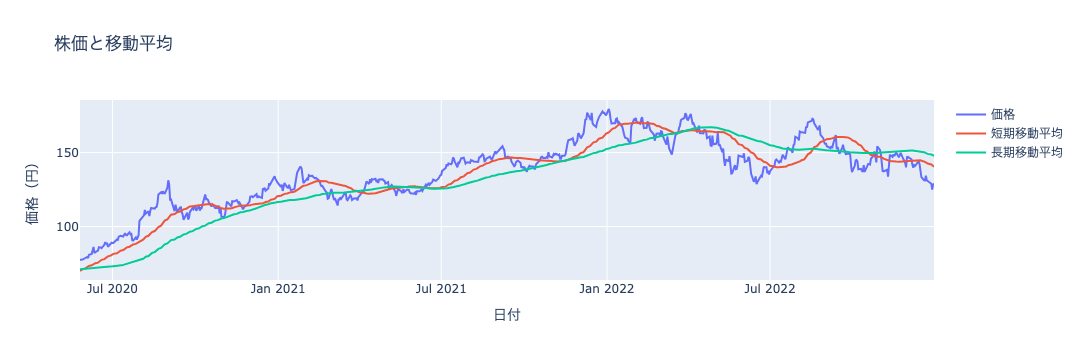

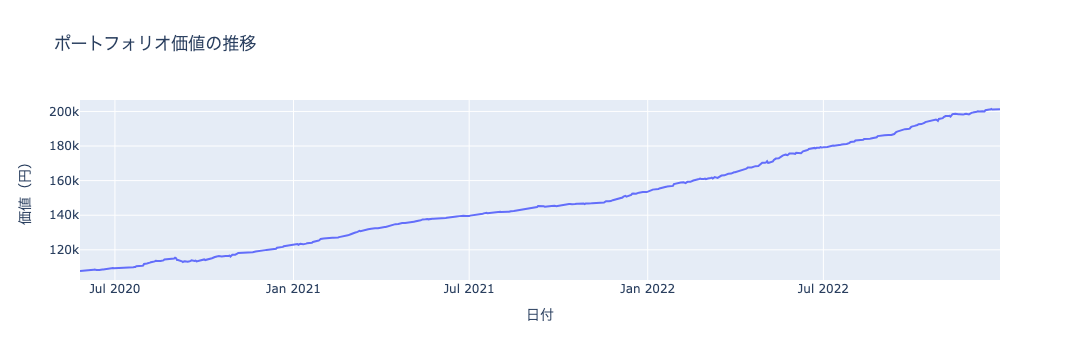

ポートフォリオの初期価値: 107733.08円
ポートフォリオの最終価値: 201310.20円
ポートフォリオの上昇率: 86.86%


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# データ取得
def get_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# 特徴量の作成
def create_features(data):
    data['short_mavg'] = data['Adj Close'].rolling(window=40).mean()
    data['long_mavg'] = data['Adj Close'].rolling(window=100).mean()
    data['bollinger_up'] = data['Adj Close'].rolling(window=20).mean() + 2*data['Adj Close'].rolling(window=20).std()
    data['bollinger_down'] = data['Adj Close'].rolling(window=20).mean() - 2*data['Adj Close'].rolling(window=20).std()
    data['rsi'] = calculate_rsi(data['Adj Close'], window=14)
    data.dropna(inplace=True)
    return data

# RSIの計算
def calculate_rsi(series, window):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 取引ルールの適用
def apply_trading_strategy(data):
    # 特徴量の準備
    features = ['short_mavg', 'long_mavg', 'bollinger_up', 'bollinger_down', 'rsi']
    X = data[features]
    y = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, -1)

    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # モデルの訓練
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 予測の適用
    data['signal'] = model.predict(X)
    data['positions'] = data['signal'].diff()
    return data

# バックテストの実行
def backtest(signals, initial_capital=100000.0, share_size=100):
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions['NVDA'] = share_size * signals['signal']
    portfolio = positions.multiply(signals['Adj Close'], axis=0)
    pos_diff = positions.diff()

    portfolio['holdings'] = (positions.multiply(signals['Adj Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(signals['Adj Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

# プロット関数
def plot_results(signals, portfolio):
    fig = go.Figure()

    # 株価と移動平均
    fig.add_trace(go.Scatter(x=signals.index, y=signals['Adj Close'], mode='lines', name='価格'))
    fig.add_trace(go.Scatter(x=signals.index, y=signals['short_mavg'], mode='lines', name='短期移動平均'))
    fig.add_trace(go.Scatter(x=signals.index, y=signals['long_mavg'], mode='lines', name='長期移動平均'))

    # 売買シグナルのプロット
    buy_signals = signals.loc[signals.positions == 1.0]
    sell_signals = signals.loc[signals.positions == -1.0]
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Adj Close'], mode='markers', marker=dict(symbol='triangle-up', size=10, color='green'), name='買いシグナル'))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['Adj Close'], mode='markers', marker=dict(symbol='triangle-down', size=10, color='red'), name='売りシグナル'))

    fig.update_layout(title='株価と移動平均', xaxis_title='日付', yaxis_title='価格（円）')
    
    # ポートフォリオの価値
    fig_portfolio = go.Figure()
    fig_portfolio.add_trace(go.Scatter(x=portfolio.index, y=portfolio['total'], mode='lines', name='ポートフォリオ価値'))

    fig_portfolio.update_layout(title='ポートフォリオ価値の推移', xaxis_title='日付', yaxis_title='価値（円）')

    fig.show()
    fig_portfolio.show()

# 主な実行部分
if __name__ == "__main__":
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    data = get_stock_data(ticker, start_date, end_date)
    data = create_features(data)
    signals = apply_trading_strategy(data)
    portfolio = backtest(signals)
    plot_results(signals, portfolio)

    # ポートフォリオの上昇率の計算と出力
    initial_portfolio_value = portfolio['total'].iloc[0]
    final_portfolio_value = portfolio['total'].iloc[-1]
    return_percentage = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value * 100
    print(f"ポートフォリオの初期価値: {initial_portfolio_value:.2f}円")
    print(f"ポートフォリオの最終価値: {final_portfolio_value:.2f}円")
    print(f"ポートフォリオの上昇率: {return_percentage:.2f}%")
